![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [10]:
# Start your coding from below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Run OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Read in data
df_rental = pd.read_csv("rental_info.csv")
df_rental.head(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [11]:
# Add information on rental duration
df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days

In [12]:
### Add dummy variables
# Add dummy for deleted scenes
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1, 0)
# Add dummy for behind the scenes
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1, 0)


In [13]:
# Choose columns to drop
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]

# Split into feature and target sets
X = df_rental.drop(cols_to_drop, axis=1)
y = df_rental["rental_length_days"]

# Further split into training and test data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 9)  

In [14]:
# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state=9) 

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Perform feature selectin by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

Mean Squared Error for OLS on Lasso chosen features: 4.8123


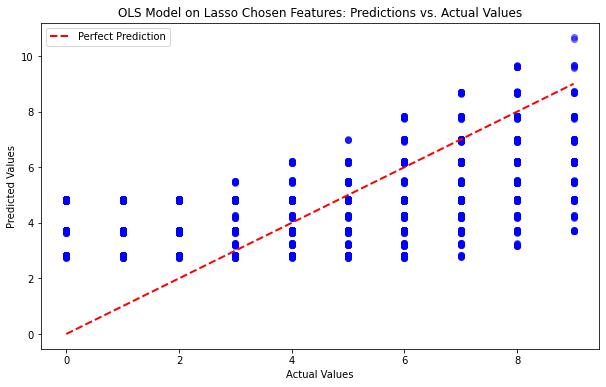

In [15]:
# Run OLS models on lasso chosen regression
ols_model = LinearRegression()
ols_model.fit(X_lasso_train, y_train)
y_test_pred = ols_model.predict(X_lasso_test)

# Calculate Mean Squared Error
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

# Print MSE
print(f"Mean Squared Error for OLS on Lasso chosen features: {mse_lin_reg_lasso:.4f}")

# Visualize predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('OLS Model on Lasso Chosen Features: Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Best Hyperparameters: {'n_estimators': 51, 'max_depth': 10}
Mean Squared Error for Random Forest: 2.2257


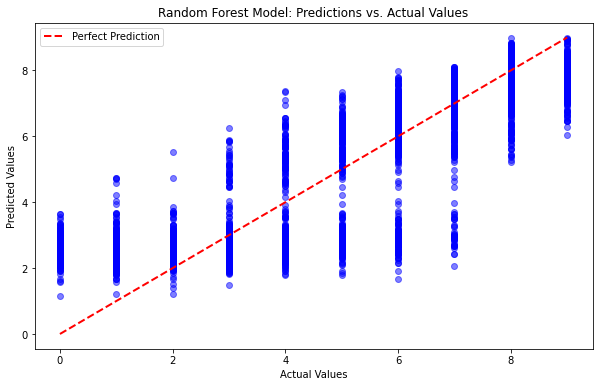

In [16]:
# Define the hyperparameter space for Random Forest
param_dist = {'n_estimators': np.arange(1, 101, 1),
              'max_depth': np.arange(1, 11, 1)}

# Create a Random Forest Regressor
rf = RandomForestRegressor()

# Use Randomized Search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, random_state=9)
rand_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyper_params = rand_search.best_params_

# Train Random Forest with the best hyperparameters
best_rf_model = RandomForestRegressor(n_estimators=best_hyper_params["n_estimators"],
                                      max_depth=best_hyper_params["max_depth"],
                                      random_state=9)
best_rf_model.fit(X_train, y_train)
rf_pred = best_rf_model.predict(X_test)

# Calculate Mean Squared Error
mse_random_forest = mean_squared_error(y_test, rf_pred)

# Print the best hyperparameters and MSE
print(f"Best Hyperparameters: {best_hyper_params}")
print(f"Mean Squared Error for Random Forest: {mse_random_forest:.4f}")

# Visualize predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('Random Forest Model: Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()